## DATA EXPLORATION

1. Find least correlated datasets
2. Distribution of prices, daily returns and drawdowns
3. Identification and definition of crashes

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from scipy.optimize import curve_fit
from matplotlib import gridspec
import sys
from pylab import rcParams
import pickle

### 1. Find least correlated datasets

Correlations of daily returns between datasets:


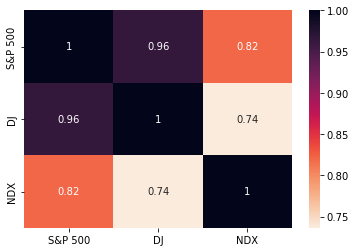

In [2]:
datasets_original = ['s&p 500.csv', 'dow jones.csv', 'nasdaq.csv']
dataset_names = ['S&P 500', 'DJ', 'NDX']
datasets = []
for d in datasets_original:
    data_original = pd.read_csv(d, index_col = 'Date')
    data_original.index = pd.to_datetime(data_original.index, format='%Y/%m/%d')
    data_norm = data_original['Close'] / data_original['Close'][-1]
    data_ch = data_original['Close'].pct_change()
    window = 10
    data_vol = data_original['Close'].pct_change().rolling(window).std()
    data = pd.concat([data_original['Close'], data_norm, data_ch, data_vol], axis=1).dropna()
    data.columns = ['price', 'norm', 'ch', 'vol']
    datasets.append(data)
    
df_ch = [d['ch'] for d in datasets]
df_returns = pd.concat(df_ch, axis=1)
df_returns.columns = dataset_names
corr = df_returns.corr()
print('Correlations of daily returns between datasets:')
ax = sns.heatmap(corr, annot=True, cmap='rocket_r')

The correlation matrix with all the 3 datasets shows the high correlation between each other, i.e., > 0.5.

## Distribution of prices, daily returns, drawdowns

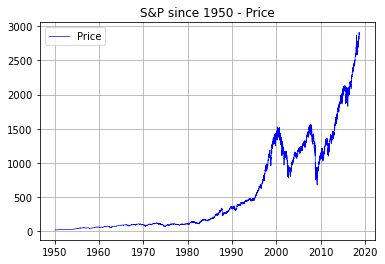

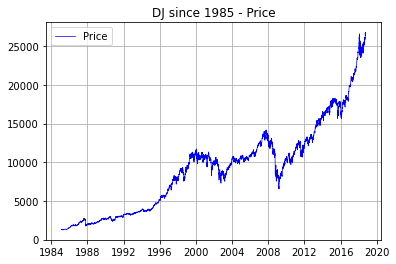

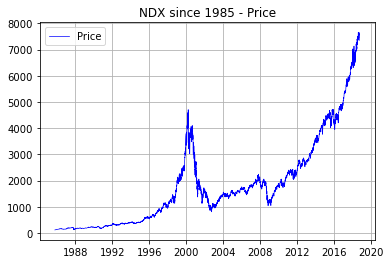

In [3]:
# Plot price over time
sp = pd.read_csv("s&p 500.csv")
dj = pd.read_csv('dow jones.csv')
ndx = pd.read_csv('nasdaq.csv')
plt_titles = ['S&P since 1950', 'DJ since 1985', 'NDX since 1985']

for ds,t in zip(datasets,plt_titles):
    plt.plot(ds['price'], color='blue', linewidth=0.7)
    plt.grid()
    plt.legend(['Price'])
    plt.title(t + ' - Price')
    plt.show()

The time series plots give an impression of the performance of the different markets over the past 50-20 years.

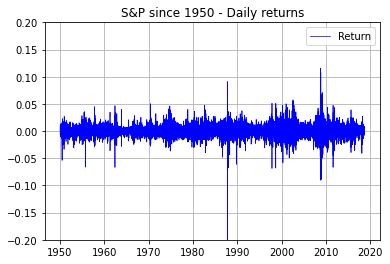

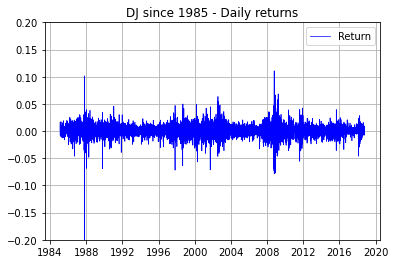

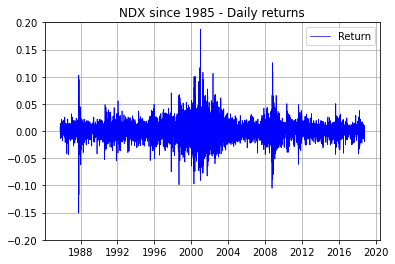

In [4]:
##### Plot daily return over time
for ds, t in zip(datasets, plt_titles):
    plt.plot(ds['ch'], color='blue', linewidth=0.7)
    plt.ylim(-0.2, 0.2)
    plt.grid()
    plt.legend(['Return'])
    plt.title(t + ' - Daily returns')
    plt.show()

The amplitude of daily returns over time for all datasets give an impression of the volatility in the different markets with the Nasdaq shows larges daily gain.

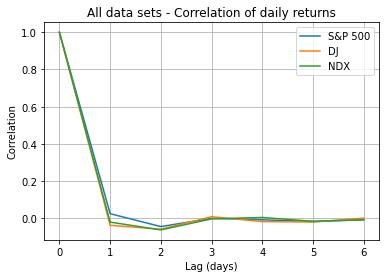

In [5]:
##### Autocorrelation
corr_ds = []
for ds, t in zip(datasets, plt_titles):
    corr = [1]
    for i in range(1, 7):
        corr.append(np.corrcoef(ds['ch'][i:], ds['ch'][:-i])[0, 1])
    plt.plot(corr)
plt.title('All data sets - Correlation of daily returns')
plt.legend(dataset_names)
plt.xlabel('Lag (days)')
plt.ylabel('Correlation')
plt.grid()
plt.show()

The autocorrelation of daily returns is close to zero for a lag > 1 day, indicating that the daily return is not a strong predictor for the price change of the following day.

### Drawdowns

To detect crashes, the drawdowns are calculated. A drawdown is a total loss over consequtive days from the last maximum to the nex minimum of the price. A drawdown occuring over n days (the period from t_1 to t_n) is described as d = (p_max - p_min)/pmax, with p_max = p(t_1) > p(t_2) > ... > p(t_n) = p_min.

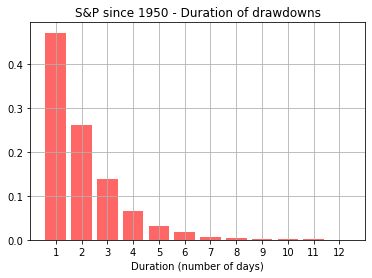

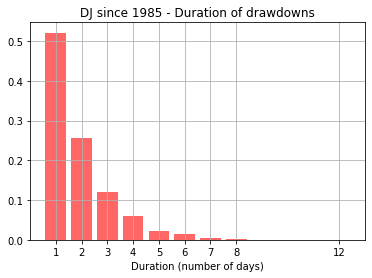

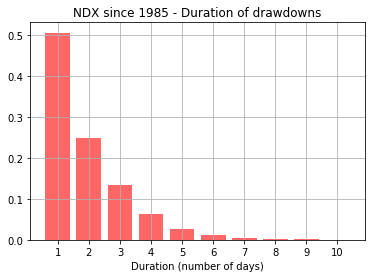

In [6]:
# Drawdowns
dd_df = []
for ds in datasets:
    pmin_pmax = (ds['price'].diff(-1) > 0).astype(int).diff() #<- -1 indicates pmin, +1 indicates pmax
    pmax = pmin_pmax[pmin_pmax == 1]
    pmin = pmin_pmax[pmin_pmax == -1]
    if pmin.index[0] < pmax.index[0]:
        pmin = pmin.drop(pmin.index[0])
    if pmin.index[-1] < pmax.index[-1]:
        pmax = pmax.drop(pmax.index[-1])
    dd = (np.array(ds['price'][pmin.index]) - np.array(ds['price'][pmax.index])) \
        / np.array(ds['price'][pmax.index])
    dur = [np.busday_count(p1.date(), p2.date()) for p1, p2 in zip(pmax.index, pmin.index)]
    d = {'Date':pmax.index, 'drawdown':dd, 'd_start': pmax.index, 'd_end': pmin.index, \
         'duration': dur}    
    df_d = pd.DataFrame(d).set_index('Date')
    df_d.index = pd.to_datetime(df_d.index, format='%Y/%m/%d')
    df_d = df_d.sort_values(by='drawdown')
    df_d['rank'] = list(range(1,df_d.shape[0]+1))
    dd_df.append(df_d)

# Plot duration of drawdowns
l_dict_dd = []
for dd, t in zip(dd_df, plt_titles):
    max_dd = max(abs(dd['drawdown']))
    m = round(max_dd+0.01,2)
    bins = np.linspace(-m, m, 800)
    d = {}
    for i in range(1, len(bins)+1):
        d[i] = bins[i-1]
    disc = np.digitize(x=dd['drawdown'], bins=bins)
    d1 = defaultdict(int)
    for i in disc:
        d1[d[i]] += 1
    l_dict_dd.append(d1)
    plt.bar(x=dd['duration'].value_counts().index, height=dd['duration'].\
        value_counts()/dd['duration'].shape[0], color='red', alpha=0.6)
    plt.xticks(dd['duration'].value_counts().index)
    plt.title(t + ' - Duration of drawdowns')
    plt.xlabel('Duration (number of days)')
    plt.grid()
    plt.show()

In [7]:
dd_df

[            drawdown    d_start      d_end  duration  rank
 Date                                                      
 1987-10-13 -0.285133 1987-10-13 1987-10-19         4     1
 2008-09-30 -0.229037 2008-09-30 2008-10-10         8     2
 1962-05-15 -0.136724 1962-05-15 1962-05-28         9     3
 2008-11-18 -0.124174 2008-11-18 2008-11-20         2     4
 1998-08-25 -0.124052 1998-08-25 1998-08-31         4     5
 ...              ...        ...        ...       ...   ...
 2017-07-14 -0.000053 2017-07-14 2017-07-17         1  4030
 2002-02-25 -0.000045 2002-02-25 2002-02-26         1  4031
 1995-01-31 -0.000043 1995-01-31 1995-02-01         1  4032
 2015-02-10 -0.000029 2015-02-10 2015-02-11         1  4033
 1992-02-10 -0.000024 1992-02-10 1992-02-11         1  4034
 
 [4034 rows x 5 columns],
             drawdown    d_start      d_end  duration  rank
 Date                                                      
 1987-10-13 -0.306767 1987-10-13 1987-10-19         4     1
 2008-09-30 

The duration of drawdown histograms show how long drawdowns typically last. For all datasets ~50% of all drawdowns last only one day, meaning that a price decrease from the previous to the current day is followed by a price increase on the next following day. This confirms the low autocorrelation identified earlier. The longest drawdowns last around 10-12 business days. However, the longest drawdwons are not necessasary responsible for the highest losses which will be apparent when we identify crashes.

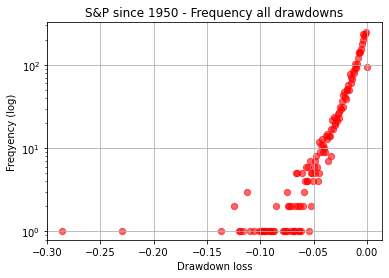

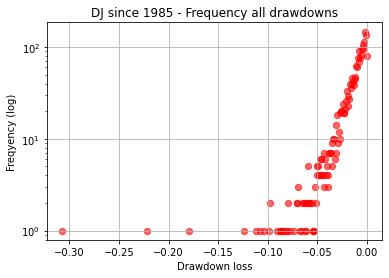

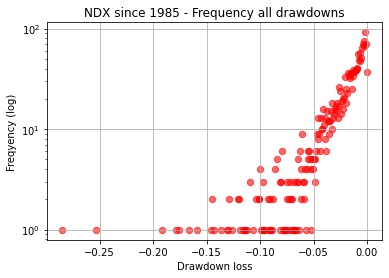

In [8]:
# Plot frequency oof drawdowns
for d1, t in zip(l_dict_dd, plt_titles):
    df_d_bins = pd.DataFrame(list(d1.items()))
    df_d_bins.columns = ['drawdown', 'n']
    plt.scatter(df_d_bins['drawdown'], df_d_bins['n'], s=40, color='red', alpha=0.6)
    plt.yscale('log')
    df_d_bins_reg = df_d_bins[df_d_bins['drawdown']>-0.08]
    m, c = np.polyfit(df_d_bins_reg['drawdown'], np.log(df_d_bins_reg['n']), 1)
    y_fit = np.exp(m*df_d_bins['drawdown'] + c)
    plt.ylim(bottom=10**-.1)
    #plt.plot(df_d_bins['drawdown'], y_fit, color='black', ls='dashed')
    plt.title(t + ' - Frequency all drawdowns')
    plt.xlabel('Drawdown loss')
    plt.ylabel('Freqyency (log)')
    plt.grid()
    plt.show()

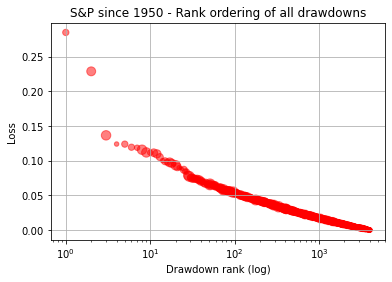

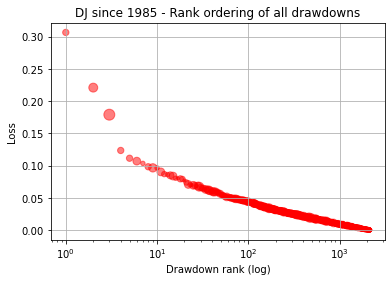

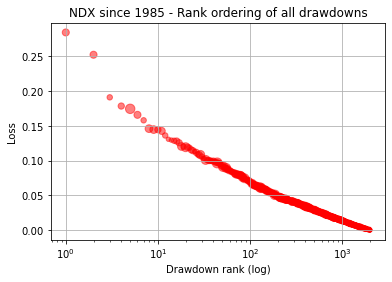

In [9]:
# Drawdown by rank
for dd, t in zip(dd_df, plt_titles):
    plt.scatter(dd['rank'], abs(dd['drawdown']), s=10*dd['duration'], alpha=0.5,\
                color='red')
    plt.xscale('log')
    plt.title(t + ' - Rank ordering of all drawdowns')
    plt.xlabel('Drawdown rank (log)')
    plt.ylabel('Loss')
    plt.grid()
    plt.show()

For rank ordering plots above, the drawdwons have been ranked from 1 (largest drawdown in dataset) to n. The size of each bubble corresponds to the duration of each drawdown and show that the largest drawdowns are not necessarily the longest ones. These plots provide further visual evidence of the existence of outliers as drawdowns that are larger than expected.

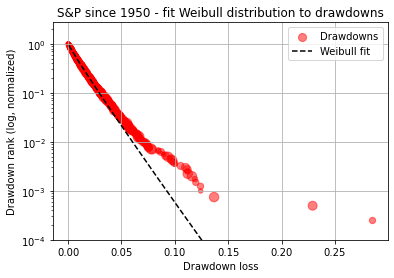

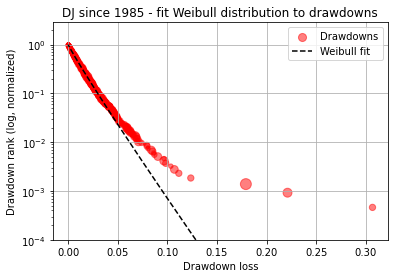

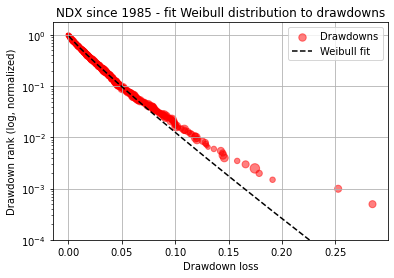

In [10]:
# Fit Weibull exponential function to drawdowns by rank
def weibull(x, chi, z):
    return np.exp(-abs(x/chi)**z)

for dd, t in zip(dd_df, plt_titles):
    x = dd['drawdown']
    y = dd['rank']/dd['rank'].max()
    init_vals = [0.9, 0.015]  # for [z, chi]
    best_vals, covar = curve_fit(weibull, abs(x), y, p0=init_vals)
    chi = best_vals[0]
    z = best_vals[1]
    plt.scatter(abs(x), y, s=10*dd['duration'], alpha=0.5, color='red')
    y_fit = [weibull(abs(xi), chi, z) for xi in x]
    plt.plot(abs(x), y_fit, color='black', ls='dashed')
    plt.yscale('log')
    plt.ylim(bottom=10**-4)
    plt.legend(['Drawdowns', 'Weibull fit'])
    plt.title(t + ' - fit Weibull distribution to drawdowns')
    plt.xlabel('Drawdown loss')
    plt.ylabel('Drawdown rank (log, normalized)')
    plt.grid()
    plt.show()


The Weibull exponential model: y ~ exp(-abs(x/chi)^z) has been used by Johansen and Sornette (2001) to fit the distributions of drawdowns by rank. As we will discuss below, large deviations from the Weibull distribution are considered to be crashes.

## 3. Identify Crashes

<html>
    <body>
        <ul>
            <li>3.1 First methodology: crashes as the 99.5% empirical quantile of the drawdowns (as suggested by Jacobsson, E., Stockholm University, in 'How to predict crashes in financial markets with the Log-Periodic Power Law', 2009).
            </li>
            <li>
                3.2 Crashes as outliers of the fitted Weibull exponential model(as suggested by Johansen, A. and Sornette, D. in 'Large Stock Market Price Drawdowns Are Outliers', 2001). This methodology requires manual identification of crashes based on the Weibull plots.
            </li>
         </ul>   
    </body>
</html>


In [11]:
# 2.1 Emilie Jacobsen, Stockholm University: empirical quantile: 99.5%
crash_thresholds = []
for dd in dd_df:
    ct = dd['drawdown'].iloc[round(dd.shape[0] * .005)]
    crash_thresholds.append(ct)

crashes = []
for df, dd, ct in zip(datasets, dd_df, crash_thresholds):
    df_d = dd.reindex(df.index).fillna(0)
    df_d = df_d.sort_values(by='Date')
    df_c = df_d[df_d['drawdown'] < ct]
    df_c.columns = ['drawdown', 'crash_st', 'crash_end', 'duration', 'rank']
    crashes.append(df_c)
df_combined = []  
for i in range(len(datasets)):
    df_combined.append(pd.concat([datasets[i], dd_df[i]], axis=1).fillna(0))
    

In [12]:
crashes

[            drawdown             crash_st            crash_end  duration  rank
 Date                                                                          
 1962-05-15 -0.136724  1962-05-15 00:00:00  1962-05-28 00:00:00       9.0   3.0
 1974-08-07 -0.097762  1974-08-07 00:00:00  1974-08-19 00:00:00       8.0  17.0
 1974-09-20 -0.112062  1974-09-20 00:00:00  1974-10-03 00:00:00       9.0   9.0
 1974-11-11 -0.096474  1974-11-11 00:00:00  1974-11-20 00:00:00       7.0  18.0
 1980-11-28 -0.093652  1980-11-28 00:00:00  1980-12-11 00:00:00       9.0  20.0
 1987-10-13 -0.285133  1987-10-13 00:00:00  1987-10-19 00:00:00       4.0   1.0
 1987-10-21 -0.118856  1987-10-21 00:00:00  1987-10-26 00:00:00       3.0   7.0
 1997-10-21 -0.098007  1997-10-21 00:00:00  1997-10-27 00:00:00       4.0  16.0
 1998-08-25 -0.124052  1998-08-25 00:00:00  1998-08-31 00:00:00       4.0   5.0
 2000-04-07 -0.105378  2000-04-07 00:00:00  2000-04-14 00:00:00       5.0  13.0
 2001-09-10 -0.116005  2001-09-10 00:00:

In [13]:
crash_thresholds

[-0.091242184995925, -0.08694104588774061, -0.14281496281387765]

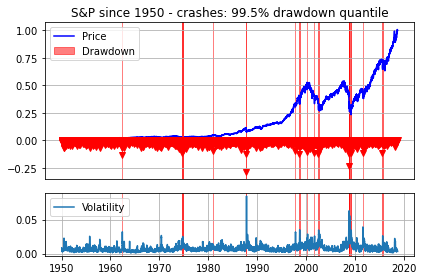

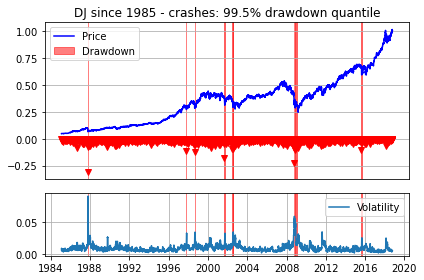

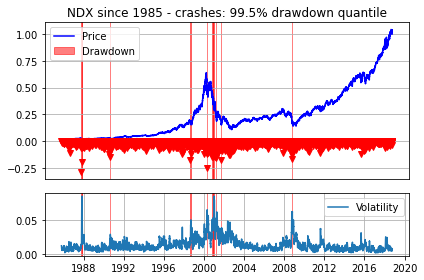

In [14]:
# 2.1 Plot crashes in time series
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 
for i in range(len(df_combined)):
    plt.subplot(gs[0])
    plt.plot(df_combined[i]['norm'], color='blue')
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crashes[i]['crash_st'], \
         crashes[i]['crash_end'])]
    plt.plot(df_combined[i]['drawdown'], color='red', marker='v',linestyle='')
    plt.title(plt_titles[i] + ' - crashes: 99.5% drawdown quantile')
    plt.grid()
    plt.xticks([])
    plt.legend(['Price', 'Drawdown'])
    plt.subplot(gs[1])
    plt.plot(df_combined[i]['vol'])
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crashes[i]['crash_st'], \
         crashes[i]['crash_end'])]
    plt.legend(['Volatility'])
    plt.grid()
    plt.tight_layout()
    plt.show()

The plots above show the price (upper plots) and price return volatility with a lag of ten days (lower plots) along with the identified crases (vertical red lines) and the magnitude of the drawdowns (red pointers). Through the method of defining a crash as a drawdown in the 99.5th precentile, the number of crashes in each dataset is related to overall time period of each dataset. This leads to an identified crash occuring on average once 2-3 years. By identifying crashes through this methodology, the drawdown threshold for identifying a crash varies strongly with markets and we do not account for the fact that some markets have much more extreme large drawdowns than others.

## 2.2 Crashes according to Johansen and Sornette

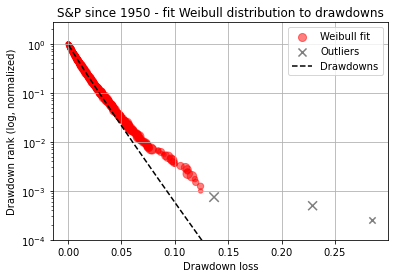

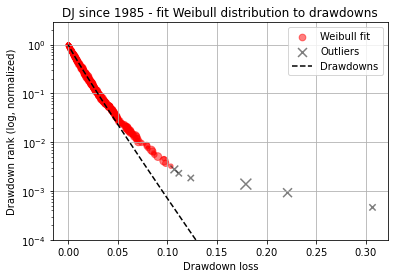

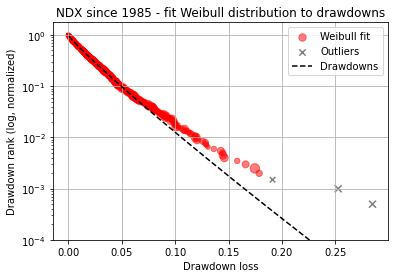

In [15]:
n_crashes = [3, 6, 3]  # <-- number of crashes manually identified based on outliers in Weibul plots below
for dd, t, n in zip(dd_df, plt_titles, n_crashes):
    x = dd['drawdown']
    y = dd['rank']/dd['rank'].max()
    init_vals = [0.9, 0.015]  # for [z, chi]
    best_vals, covar = curve_fit(weibull, abs(x), y, p0=init_vals)
    chi = best_vals[0]
    z = best_vals[1]
    plt.scatter(abs(x[n:]), y[n:], s=10*dd['duration'][n:], alpha=0.5, color='red')
    plt.scatter(abs(x[:n]), y[:n], s=10*dd['duration'][:n], alpha=0.5, color='black', marker='x')
    y_fit = [weibull(abs(xi), chi, z) for xi in x]
    plt.plot(abs(x), y_fit, color='black', ls='dashed')
    plt.yscale('log')
    plt.ylim(bottom=10**-4)
    plt.legend(['Weibull fit', 'Outliers', 'Drawdowns'])
    plt.title(t + ' - fit Weibull distribution to drawdowns')
    plt.xlabel('Drawdown loss')
    plt.ylabel('Drawdown rank (log, normalized)')
    plt.grid()
    plt.show()

The Weibull fit plots above are the same ones as shown under 2. but this time with the "x"s identifying outliers that cannot be explained by the Weibull distribution. As Johansen and Sornette do not give a specific threshold deviation from the distribution that identifies a crash, the identification of crashes above has been conducted based on visual interpretation.

In [16]:
crashes = []
for df, dd, r in zip(datasets, dd_df, n_crashes):
    df_c = dd[dd['rank'] <= r]
    df_c.columns = ['drawdown', 'crash_st', 'crash_end', 'duration', 'rank']
    crashes.append(df_c)
for c, t in zip(crashes, plt_titles):
    c['crash_st'] = c['crash_st'].dt.date
    c['crash_end'] = c['crash_end'].dt.date
    c['duration'] = c['duration'].astype(int)
    c['rank'] = c['rank'].astype(int)
    print(t + ' - all crashes (Weibull outliers):')
    display(c)
    print('\n')

S&P since 1950 - all crashes (Weibull outliers):


C:\Users\Meetul\AppData\Local\Temp\ipykernel_14252\3972141665.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['crash_st'] = c['crash_st'].dt.date
C:\Users\Meetul\AppData\Local\Temp\ipykernel_14252\3972141665.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['crash_end'] = c['crash_end'].dt.date
C:\Users\Meetul\AppData\Local\Temp\ipykernel_14252\3972141665.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

,drawdown,crash_st,crash_end,duration,rank
Date,,,,,
1987-10-13,-0.285133,1987-10-13,1987-10-19,4,1
2008-09-30,-0.229037,2008-09-30,2008-10-10,8,2
1962-05-15,-0.136724,1962-05-15,1962-05-28,9,3




DJ since 1985 - all crashes (Weibull outliers):


C:\Users\Meetul\AppData\Local\Temp\ipykernel_14252\3972141665.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['crash_st'] = c['crash_st'].dt.date
C:\Users\Meetul\AppData\Local\Temp\ipykernel_14252\3972141665.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['crash_end'] = c['crash_end'].dt.date
C:\Users\Meetul\AppData\Local\Temp\ipykernel_14252\3972141665.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

,drawdown,crash_st,crash_end,duration,rank
Date,,,,,
1987-10-13,-0.306767,1987-10-13,1987-10-19,4,1
2008-09-30,-0.221136,2008-09-30,2008-10-10,8,2
2001-09-05,-0.179150,2001-09-05,2001-09-21,12,3
1998-08-25,-0.123634,1998-08-25,1998-08-31,4,4
1997-10-21,-0.111558,1997-10-21,1997-10-27,4,5
2015-08-17,-0.107080,2015-08-17,2015-08-25,6,6


C:\Users\Meetul\AppData\Local\Temp\ipykernel_14252\3972141665.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['crash_st'] = c['crash_st'].dt.date
C:\Users\Meetul\AppData\Local\Temp\ipykernel_14252\3972141665.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['crash_end'] = c['crash_end'].dt.date




NDX since 1985 - all crashes (Weibull outliers):


C:\Users\Meetul\AppData\Local\Temp\ipykernel_14252\3972141665.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['duration'] = c['duration'].astype(int)
C:\Users\Meetul\AppData\Local\Temp\ipykernel_14252\3972141665.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['rank'] = c['rank'].astype(int)


,drawdown,crash_st,crash_end,duration,rank
Date,,,,,
1987-10-13,-0.284600,1987-10-13,1987-10-20,5,1
2000-04-07,-0.252490,2000-04-07,2000-04-14,5,2
1987-10-21,-0.191176,1987-10-21,1987-10-26,3,3


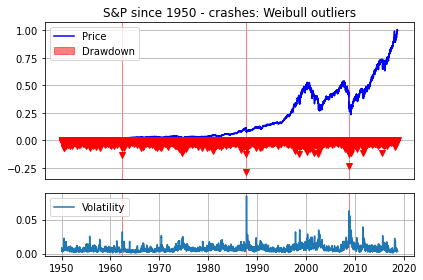

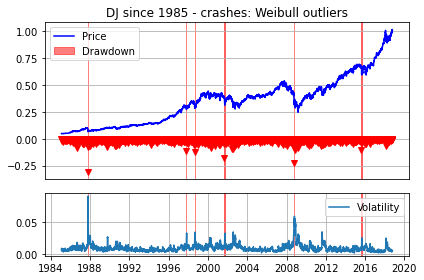

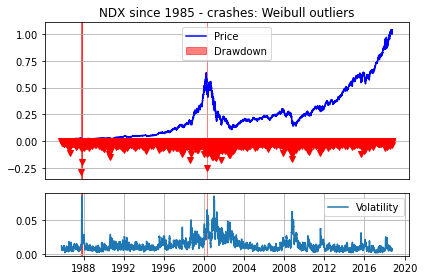

In [17]:
# 2.2 Plot crashes in time series
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 
for i in range(len(df_combined)):
    plt.subplot(gs[0])
    plt.plot(df_combined[i]['norm'], color='blue')
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crashes[i]['crash_st'], \
         crashes[i]['crash_end'])]
    plt.plot(df_combined[i]['drawdown'], color='red', marker='v',linestyle='')
    plt.title(plt_titles[i] + ' - crashes: Weibull outliers')
    plt.grid()
    plt.xticks([])
    plt.legend(['Price', 'Drawdown'])
    plt.subplot(gs[1])
    plt.plot(df_combined[i]['vol'])
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crashes[i]['crash_st'], \
         crashes[i]['crash_end'])]
    plt.legend(['Volatility'])
    plt.grid()
    plt.tight_layout()
    plt.show()


Identifying crashes based on drawdown outliers results in a number of crahes that doesn't necessarily correspond to the total number of drawdowns in a dataset.

### EDA - Conclusion

Since there is no consensus on the exact definition of a financial crash, both, the method introduced by Jacobsson (99.5% quantile of drawdowns) and the method introduced by Johansen and Sornette (outliers identified with the Weibull exponential model) can be used as an approach to identify crashes. Will be using the quantile method as it is unambiguous (no manual interpretation of outliers required) and leads to a number of crashes which proportional to the length of each dataset and therefore reduces the risk of overfitting crash patterns in certain datasets.

# Predicting Crashes in Financial Markets - Linear Regression

In [18]:
from keras import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.callbacks import ModelCheckpoint
from sklearn import metrics
from datetime import datetime, timedelta
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from prepare_data_RNN import DataLoader
from evaluate_results import EvaluateResults

In [19]:
datasets_original = ['s&p 500.csv', 'dow jones.csv', 'nasdaq.csv']
dataset_names = ['S&P 500', 'DJ', 'NDX']
# crashes according to Jacobsson:
crash_thresholds = [-0.091242184995925, -0.08694104588774061, -0.14281496281387765]

data = DataLoader(datasets_original, dataset_names)

datasets_revised, crashes = data.get_data_revised(crash_thresholds)

months = [1, 3, 6]     # <-- predict if crash n months ahead
sequence = 10          # <-- number of days lookback as input(only if select_features=False)
additional_feat = True # <-- add mean price change and vol for 4 time widnows over 252 days
batch_size = 60        # <-- batch size needs to be specified to satisfy stateful=True
dfs_x1, dfs_x2, dfs_y = data.get_df_xy(months=months, sequence=sequence, \
                            batch_size=batch_size, additional_feat=additional_feat)

In [20]:
# -------------------- RNN LSTM model -------------------- #
model_name = 'RNN LSTM'
neurons = 50
dropout = 0
optimizer = 'adam'
loss = 'binary_crossentropy'
activation = 'sigmoid'
inp_dim = 2   # <-- 1 if price change only, 2 if volatility as well
inp_tsteps = sequence + 4 * additional_feat
def rnn_lstm(inp_tsteps, inp_dim, neurons, dropout):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(inp_tsteps, inp_dim), return_sequences=True))
    model.add(LSTM(neurons, return_sequences=False))
    model.add(Dense(3, activation=activation))
    return model
model = rnn_lstm(neurons=neurons, inp_tsteps=inp_tsteps, inp_dim=inp_dim, dropout=dropout)
model.compile(loss=loss, optimizer=optimizer)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 50)            10600     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 3)                 153       
                                                                 
Total params: 30,953
Trainable params: 30,953
Non-trainable params: 0
_________________________________________________________________


In [21]:
# -------------------- Train and test RNN LSTM model -------------------- #
epochs = 20
test_data = 'S&P 500'
index_test = [i for i, name in enumerate(dataset_names) if name == test_data][0]
training_set_names = list(dataset_names)
training_set_names.pop(index_test)
dfs_x1_training = list(dfs_x1)
dfs_x1_training.pop(index_test)
dfs_x2_training = list(dfs_x2)
dfs_x2_training.pop(index_test)
dfs_y_training = list(dfs_y)
dfs_y_training.pop(index_test)

for val_data in training_set_names:
    model = rnn_lstm(neurons=neurons, inp_tsteps=inp_tsteps, inp_dim=inp_dim, dropout=dropout)
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    np_x1_train, np_x2_train, np_y_train, _, _, _ = data.get_train_test(dfs_x1_training,\
            dfs_x2_training, dfs_y_training, training_set_names, test_data=val_data)
    np_x_train = np.concatenate([np_x1_train, np_x2_train], axis=2)
    print('Train ' + str(model_name) + ' - validation data: ' + str(val_data))
    for e in range(epochs):
        model.fit(np_x_train, np_y_train, epochs=1, batch_size=batch_size, verbose=0, shuffle=True)
        if (e + 1) % 2 == 0:
            model.save_weights('stateless_s10_2d_bce_{0}_{1}.hdf5'.format(val_data, e + 1))

Train RNN LSTM - validation data: DJ
Train RNN LSTM - validation data: NDX


In [22]:
# -------------------- Load weights and predict results -------------------- #
epoch = 10 # <-- change to load model weights from previous epochs
y_train_all, y_val_all = [], []
y_pred_train_all, y_pred_val_all = [], []
for val_data in training_set_names:
    np_x1_train, np_x2_train, np_y_train, np_x1_val, np_x2_val, np_y_val = \
        data.get_train_test(dfs_x1_training, dfs_x2_training, dfs_y_training, \
                training_set_names, test_data=val_data)
    np_x_train = np.concatenate([np_x1_train, np_x2_train], axis=2)
    np_x_val = np.concatenate([np_x1_val, np_x2_val], axis=2)
    y_train_all.append(np_y_train)
    y_val_all.append(np_y_val)
    model.load_weights('stateless_s10_2d_bce_{0}_{1}.hdf5'.format(val_data, epoch))
    y_pred_train = model.predict(np_x_train, batch_size=batch_size, verbose=True) 
    y_pred_train_all.append(y_pred_train)
    y_pred_val = model.predict(np_x_val, batch_size=batch_size, verbose=True)
    y_pred_val_all.append(y_pred_val)

132/132 [==============================] - 1s 10ms/step


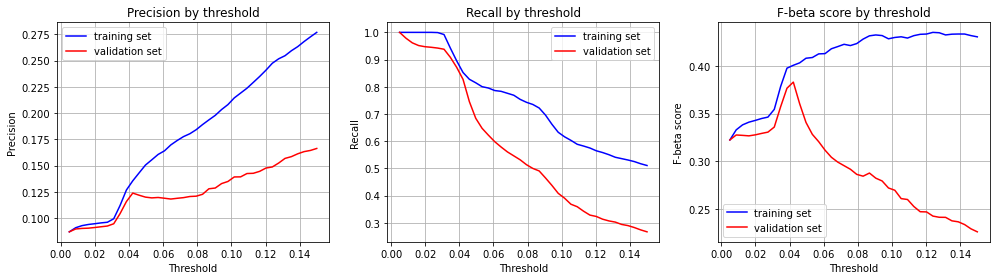

In [30]:
# -------------------- Find best threshold -------------------- #
month_prediction = 6
index_month = [i for i, m in enumerate(months) if m == month_prediction][0]
y_train_all_ = [y[:, index_month] for y in y_train_all]
y_val_all_ = [y[:, index_month] for y in y_val_all]
y_pred_train_all_ = [y[:, index_month] for y in y_pred_train_all]
y_pred_val_all_ = [y[:, index_month] for y in y_pred_val_all]
beta = 2
rcParams['figure.figsize'] = 14, 4
eval_ = EvaluateResults(y_train_all_, y_val_all_, y_pred_train_all_, y_pred_val_all_, model_name, test_data)
eval_.find_threshold(beta=beta, threshold_min=0.005, threshold_max=0.15, resolution=40)

In [31]:
# -------------------- Evaluate results -------------------- #
threshold = 0.07
beta = 2
print(model_name)
print('\n')
print('Predict crash in:               ' + str(month_prediction) + ' months')
print('Threshold for positives:        ' + str(threshold))
print('Number of features:             ' + str(dfs_x1[0].shape[1] + dfs_x2[0].shape[1]))
print('Number of rows in training set: ' + str(len(y_pred_train_all[0]) + len(y_pred_val_all[0])))
print('Number of epochs:               ' + str(epoch))
print('Sequence length:                ' + str(sequence))
print('Number of neurons/layer:        ' + str(neurons))
print('Batch size:                     ' + str(batch_size))
print('Optimizer:                      ' + str(optimizer))
print('Loss function:                  ' + str(loss))
print('\n')
eval_.training_results(threshold, training_set_names, beta=beta)

RNN LSTM


Predict crash in:               6 months
Threshold for positives:        0.07
Number of features:             28
Number of rows in training set: 16020
Number of epochs:               10
Sequence length:                10
Number of neurons/layer:        50
Batch size:                     60
Optimizer:                      adam
Loss function:                  binary_crossentropy


Results for each train/val split:
                         DJ   NDX
positive actual train  0.09  0.09
positive pred train    0.22  0.70
precision train        0.23  0.12
recall train           0.58  0.97
accuracy_train         0.79  0.38
score_fbeta train      0.44  0.40
positive actual val    0.09  0.09
positive pred val      0.20  0.64
precision val          0.13  0.11
recall val             0.30  0.81
accuracy val           0.77  0.42
score fbeta val        0.23  0.36


Results - average over all train/val splits:
Positive train cases actual:            0.09
Positive train cases predicted:        

In [32]:
# -------------------- Train model on all training data for testing -------------------- #
test_data = 'S&P 500'
np_x1_train, np_x2_train, np_y_train, np_x1_test, np_x2_test, np_y_test = \
    data.get_train_test(dfs_x1, dfs_x2, dfs_y, dataset_names, test_data=test_data)
np_x_train = np.concatenate([np_x1_train, np_x2_train], axis=2)
np_x_test = np.concatenate([np_x1_test, np_x2_test], axis=2)
epochs = 10
model = rnn_lstm(neurons=neurons, inp_tsteps=inp_tsteps, inp_dim=inp_dim, dropout=dropout)
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
print('Train model for testing ' + str(model_name) + ' - test data: ' + str(test_data))
for e in range(epochs):
    model.fit(np_x_train, np_y_train, epochs=1, batch_size=batch_size, verbose=1, shuffle=True)
    if (e + 1) % 2 == 0:
        model.save_weights('stateless_s10_2d_bce_{0}_{1}.hdf5'.format(test_data, e + 1))

Train model for testing RNN LSTM - test data: S&P 500
267/267 [==============================] - 9s 33ms/step - loss: 0.1599 - accuracy: 0.0443


In [33]:
# -------------------- Test model -------------------- #
test_data = 'S&P 500'
epoch = 10
threshold=0.07
month_prediction = 3   # <-- predict crash in 1, 3 or 6 months
index_month = [i for i, m in enumerate(months) if m == month_prediction][0]
_, _, _, np_x1_test, np_x2_test, np_y_test = \
    data.get_train_test(dfs_x1, dfs_x2, dfs_y, dataset_names, test_data=test_data)
np_x_test = np.concatenate([np_x1_test, np_x2_test], axis=2)
model.load_weights('stateless_s10_2d_bce_{0}_{1}.hdf5'.format(test_data, epoch))
y_pred_test = model.predict(np_x_test, batch_size=batch_size)[:, index_month]
y_test = np_y_test[:, index_month]
y_pred_test_bin = eval_.test_results(y_test, y_pred_test, threshold, beta=beta)

281/281 [==============================] - 4s 11ms/step
Test results (test set: S&P 500):
Positive test cases actual:         0.04
Positive test cases predicted:      0.19
Precision test (model/random):      0.12 / 0.04
Recall test (model/random):         0.55 / 0.19
Accuracy test (model/random):       0.81 / 0.78
Score test fbeta:                   0.32 / 0.11


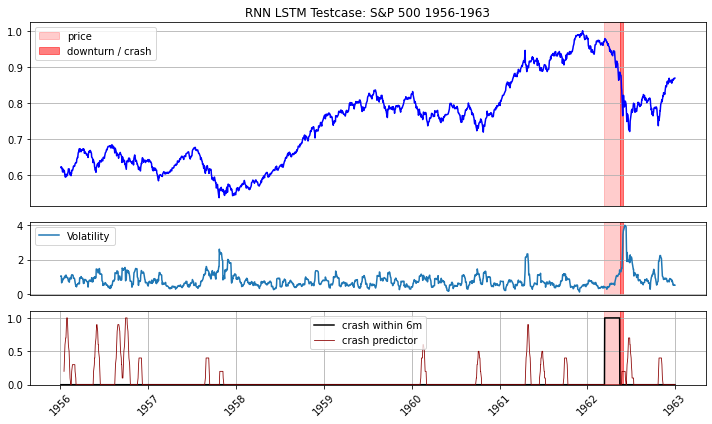

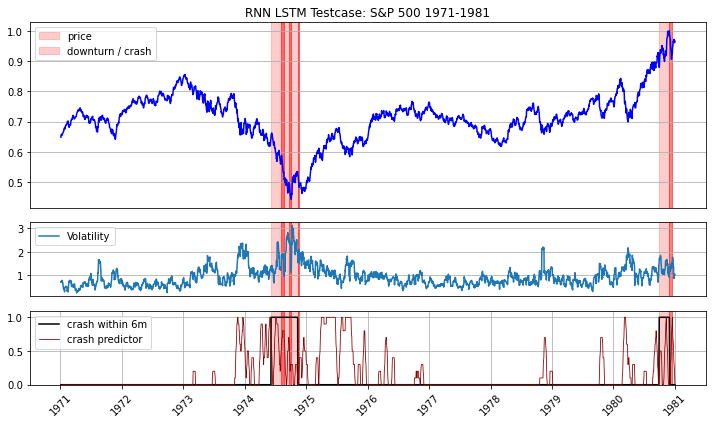

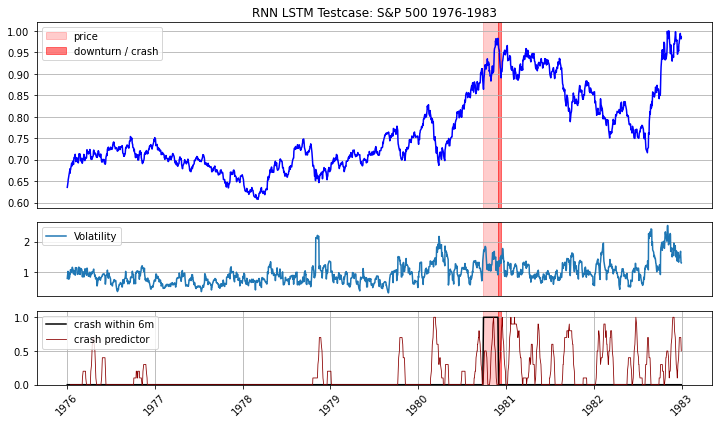

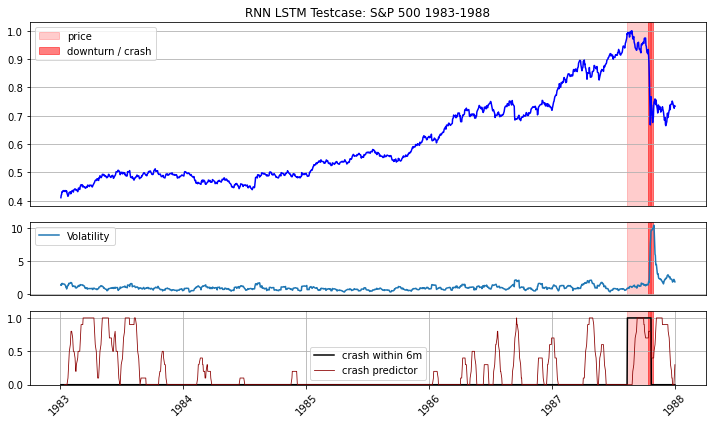

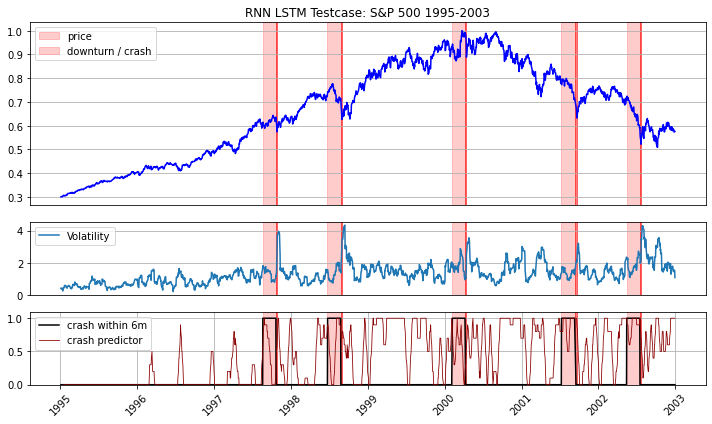

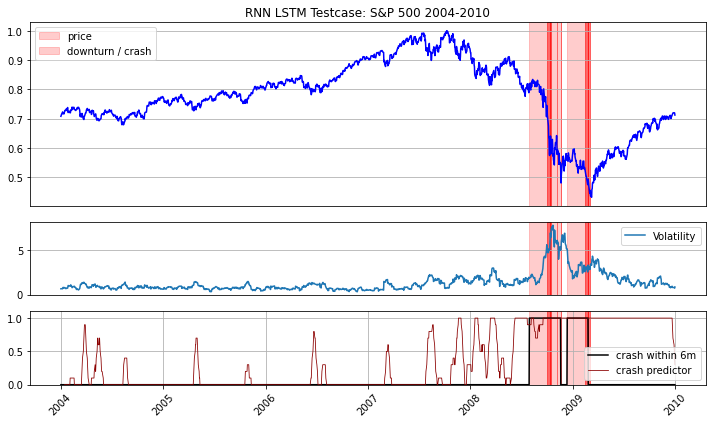

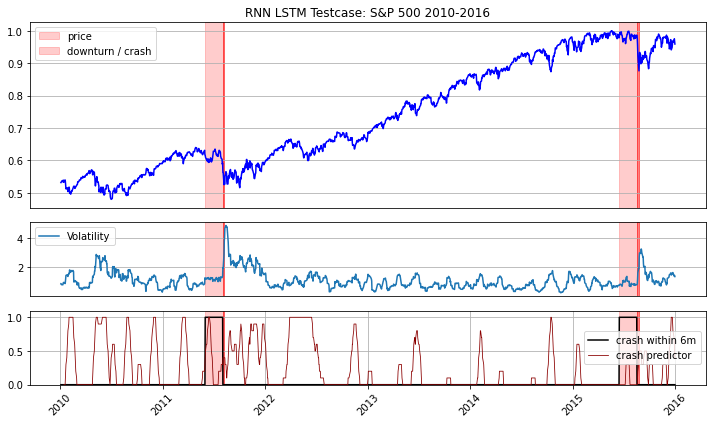

In [34]:
# -------------------- Plot test results -------------------- #
df = datasets_revised[index_test].reindex(dfs_x1[index_test].index)
df['y'] = y_test
df['y_pred'] = y_pred_test_bin
c = crashes[index_test]
t_start = ['1956-01-01', '1971-01-01', '1976-01-01', '1983-01-01', '1995-01-01', '2004-01-01', '2010-01-01']
t_end = ['1963-01-01', '1981-01-01', '1983-01-01', '1988-01-01', '2003-01-01', '2010-01-01', '2016-01-01']
rcParams['figure.figsize'] = 10, 6
eval_.plot_test_results(df, c, t_start, t_end)

In [28]:
with open('model_pickle','wb') as f:
    pickle.dump(model,f)

INFO:tensorflow:Assets written to: ram://3eb6f3a4-2b17-410c-b291-6bbc0cb8c7b9/assets


INFO:tensorflow:Assets written to: ram://3eb6f3a4-2b17-410c-b291-6bbc0cb8c7b9/assets


In [29]:
np_x_test

array([[[-0.28772633,  1.06464904],
        [-1.07148319,  1.05449467],
        [ 0.6455904 ,  0.99049685],
        ...,
        [ 0.2001506 ,  1.54695225],
        [ 0.1278409 ,  1.10132521],
        [ 0.10290156,  1.19904413]],

       [[-1.29723274,  1.12659532],
        [-0.28772633,  1.06464904],
        [-1.07148319,  1.05449467],
        ...,
        [ 0.16826748,  1.55352681],
        [ 0.12010705,  1.11183936],
        [ 0.12067695,  1.19909336]],

       [[ 0.58144452,  1.11497997],
        [-1.29723274,  1.12659532],
        [-0.28772633,  1.06464904],
        ...,
        [ 0.24038481,  1.55112588],
        [ 0.09682031,  1.1105272 ],
        [ 0.10756058,  1.20172528]],

       ...,

       [[-0.54255057,  0.49707017],
        [ 1.03901655,  0.54087233],
        [ 1.08274156,  0.52652706],
        ...,
        [ 0.19431714,  0.50152373],
        [ 0.12043496,  0.36341479],
        [ 0.0712749 ,  0.55602845]],

       [[ 1.44932892,  0.51579603],
        [-0.54255057,  0.49